E0000 00:00:1767478808.582114      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767478808.654664      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767478809.260261      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767478809.260293      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767478809.260296      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767478809.260297      17 computation_placer.cc:177] computation placer already registered. Please check linka

[INFO] TensorFlow em CPU. GPUs visíveis: []


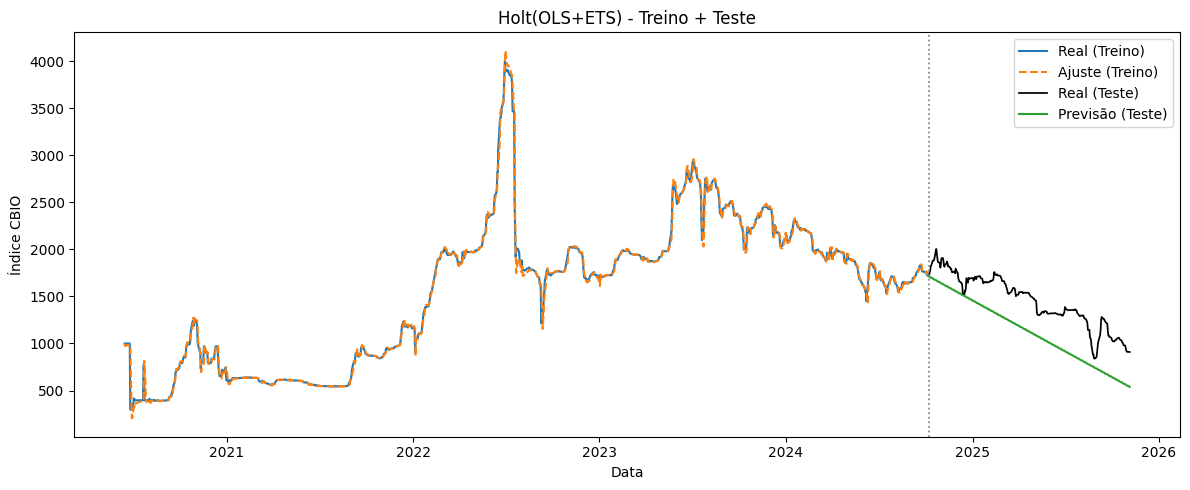

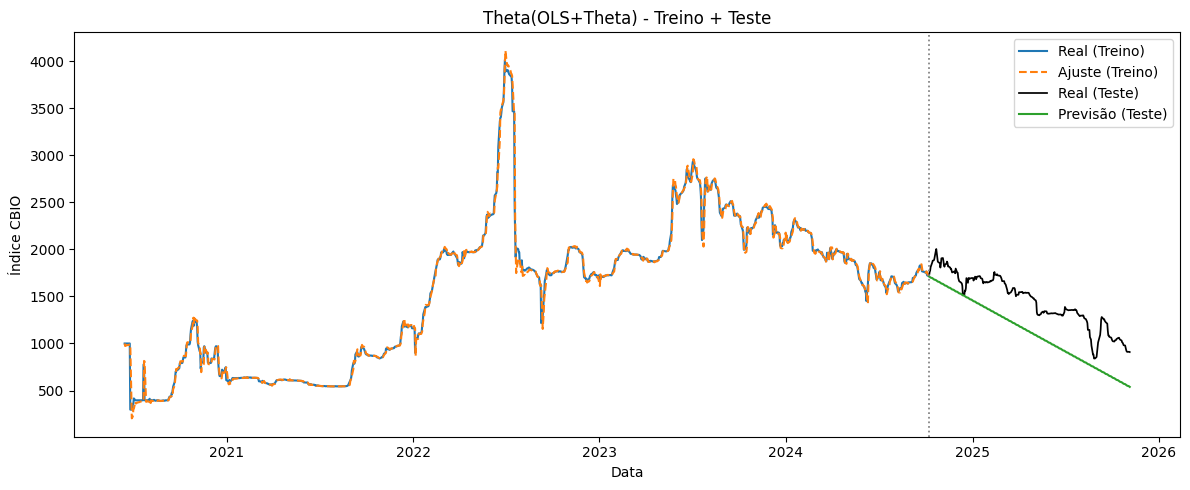

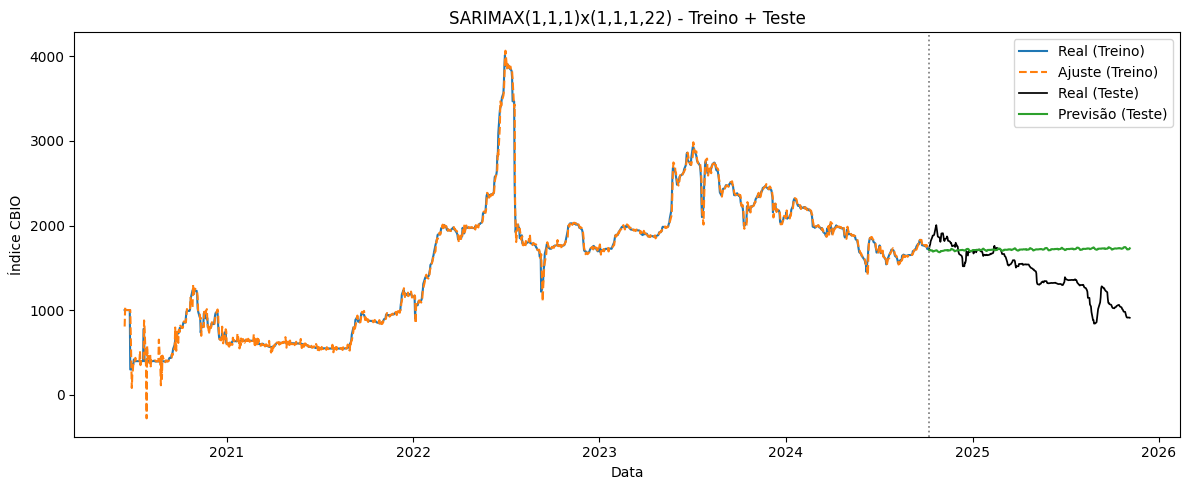

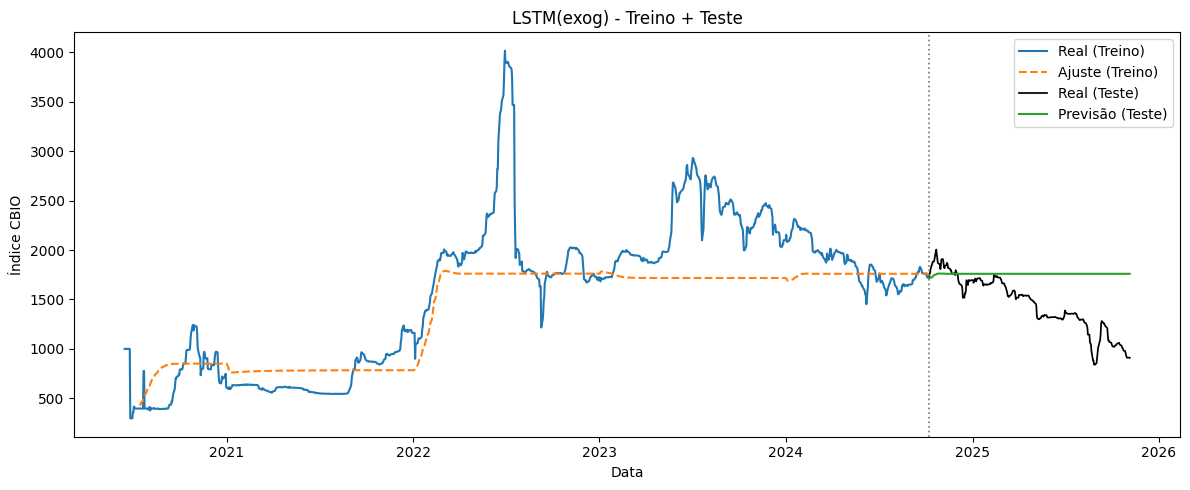


Métricas (teste):
                        Modelo           MSE       RMSE        MAE  sMAPE(%)
                 Holt(OLS+ETS) 120396.441226 346.981903 327.392713 28.168102
         ThetaModel(OLS+Theta) 120396.441226 346.981903 327.392713 28.168102
SARIMAX(1, 1, 1)x(1, 1, 1, 22) 152248.676684 390.190565 303.560655 20.623885
                    LSTM(exog) 172220.935190 414.995103 329.774589 22.091558

=== Deployment (+22 dias úteis) ===
Melhor modelo: Holt(OLS+ETS)
Horizonte    : 10 dias úteis
Início       : 2025-11-06 | Fim: 2025-11-19
Arquivo CSV  : resultados_cbio_pipeline/forecast_deployment_10bdays.csv


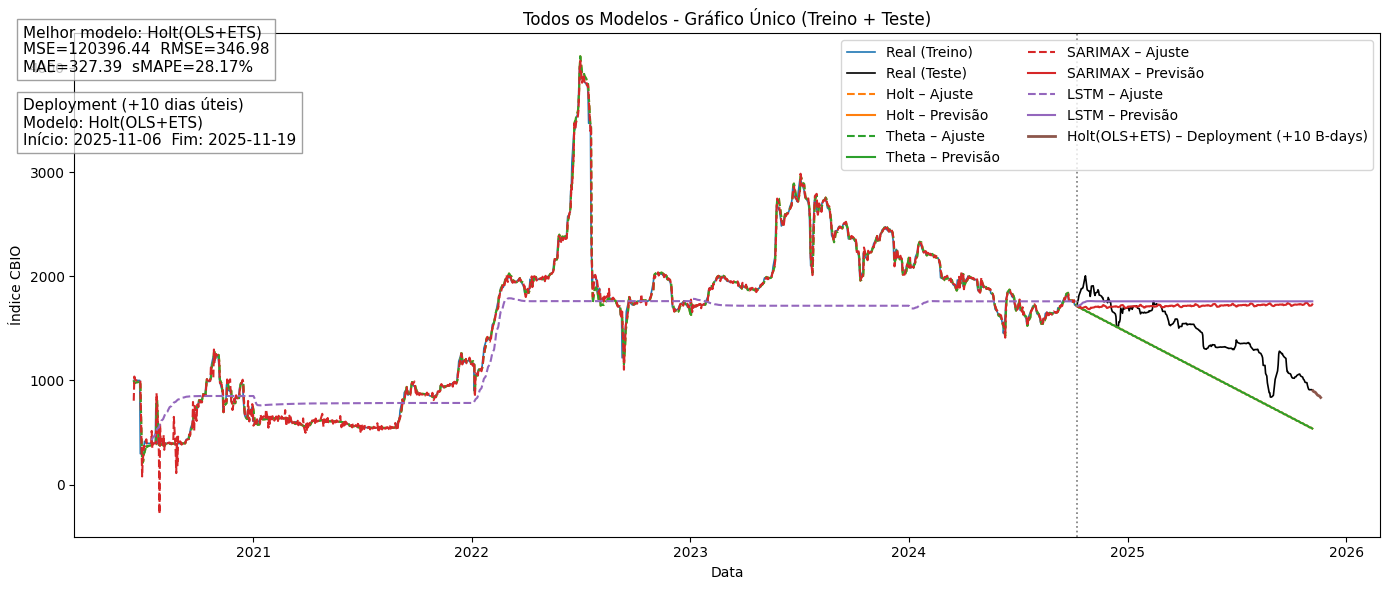

In [1]:

# ============================================================
# CBIO – Treino+Teste por modelo + Gráfico único final + Deployment (+10 B-days)
# Modelos: Holt(OLS+ETS), Theta(OLS+Theta), SARIMAX(1,1,1)x(1,1,1,22), LSTM(exog)
# ============================================================

import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gráficos inline + fonte Unicode robusta
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------- Forçar CPU no TF (evita CUDA/cuInit) ----------
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

TF_READY = False
try:
    import random
    import tensorflow as tf
    try:
        tf.config.set_visible_devices([], 'GPU')  # oculta GPUs antes da inicialização
    except Exception:
        pass
    os.environ['PYTHONHASHSEED'] = '42'
    random.seed(42); np.random.seed(42); tf.random.set_seed(42)

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TF_READY = True
    tf.get_logger().setLevel('ERROR')
    print('[INFO] TensorFlow em CPU. GPUs visíveis:', tf.config.list_physical_devices('GPU'))
except Exception as e:
    print('[AVISO] TensorFlow/Keras indisponível. LSTM será pulado. Detalhe:', e)

# ---------- Config ----------
DATA_PATH = "/kaggle/input/cbio-gee/ICBIO_csv.csv"
EXOG_PATH = "/kaggle/input/cbio-gee/EmissoesBrutasGEE.csv"
SEASONAL_M = 22
LOOKBACK   = 22
HORIZON    = 10   # +10 dias úteis para deployment

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)
    d = np.abs(y_true) + np.abs(y_pred)
    d[d == 0] = 1e-8
    return np.mean(2.0 * np.abs(y_pred - y_true) / d) * 100.0

def safe_text(s):  # evita caracteres problemáticos
    return s.replace('–','-').replace('—','--')

# ---------- Leitura ----------
def read_cbio_series(path_csv: str) -> pd.Series:
    df = pd.read_csv(path_csv, sep=';', decimal=',', encoding='utf-8')
    df['Data_Referencia'] = pd.to_datetime(df['Data_Referencia'], format='%d-%m-%Y', errors='coerce')
    df = df.sort_values('Data_Referencia').drop_duplicates('Data_Referencia', keep='last')
    s = df.set_index('Data_Referencia')['Indice'].astype(float)
    idx = pd.date_range(s.index.min(), s.index.max(), freq='B')
    s = s.reindex(idx).ffill().bfill()
    s.name = 'Indice'
    return s

def read_exog_emissions(path_csv: str) -> pd.Series:
    raw = pd.read_csv(path_csv, sep=';', decimal=',', header=None, encoding='utf-8')
    raw[0] = raw[0].astype(str).str.strip()
    idx_years = raw[raw[0].str.contains('Atividade geral', case=False, na=False)].index
    idx_prod  = raw[raw[0].str.contains('Produção de combustíveis', case=False, na=False)].index
    if len(idx_years)==0 or len(idx_prod)==0:
        # fallback para localizar linha de anos
        candidate = None
        for ridx in raw.index:
            toks = raw.loc[ridx][1:].astype(str).str.strip()
            years = toks.str.extract(r'(\d{4})')[0]
            if years.notna().sum() >= 5:
                candidate = ridx; break
        if candidate is None or len(idx_prod)==0:
            raise ValueError('Não localizadas linhas de anos ou "Produção de combustíveis".')
        years_row = raw.loc[candidate][1:].dropna()
    else:
        years_row = raw.loc[idx_years[0]][1:].dropna()
    years_clean = years_row.astype(str).str.strip().str.replace(',', '.', regex=False)
    years_num   = pd.to_numeric(years_clean, errors='coerce').dropna().astype(int)
    vals_raw    = raw.loc[idx_prod[0]][1:1+len(years_row)].astype(str)
    vals_clean  = vals_raw.str.replace(',', '.', regex=False)
    vals_num    = pd.to_numeric(vals_clean, errors='coerce')
    n = int(min(len(years_num), len(vals_num)))
    exog_year = pd.Series(vals_num.iloc[:n].values, index=years_num.iloc[:n].values, name='GEE_Combustiveis').ffill().bfill()
    return exog_year

def map_exog_to_business_days(s_cbio: pd.Series, exog_year: pd.Series) -> pd.Series:
    yrs = s_cbio.index.year
    vals = [exog_year.get(int(y), np.nan) for y in yrs]
    return pd.Series(vals, index=s_cbio.index, name='GEE_Combustiveis').ffill().bfill()

serie     = read_cbio_series(DATA_PATH)
exog_year = read_exog_emissions(EXOG_PATH)
exog_daily= map_exog_to_business_days(serie, exog_year)

# Split 80/20
split_idx = int(len(serie)*0.8)
y_train, y_test   = serie.iloc[:split_idx], serie.iloc[split_idx:]
ex_train, ex_test = exog_daily.iloc[:split_idx], exog_daily.iloc[split_idx:]

# ---------- Modelos clássicos ----------
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_holt_ols_ets(y_train: pd.Series, ex_train: pd.Series):
    X = np.column_stack([np.ones(len(ex_train)), ex_train.values])
    beta = np.linalg.lstsq(X, y_train.values, rcond=None)[0]
    resid = y_train.values - (X @ beta)
    ets   = ExponentialSmoothing(resid, trend='add', seasonal=None).fit(optimized=True)
    return beta, ets

def forecast_holt_ols_ets(beta, ets, ex_series: pd.Series):
    X = np.column_stack([np.ones(len(ex_series)), ex_series.values])
    y_hat = X @ beta
    resid_fore = ets.forecast(len(ex_series))
    return y_hat + resid_fore

def train_theta_ols(y_train: pd.Series, ex_train: pd.Series):
    X = np.column_stack([np.ones(len(ex_train)), ex_train.values])
    beta = np.linalg.lstsq(X, y_train.values, rcond=None)[0]
    resid = y_train.values - (X @ beta)
    ses   = ExponentialSmoothing(resid, trend='add', seasonal=None).fit(optimized=True)
    return beta, ses

def forecast_theta_ols(beta, ses, ex_series: pd.Series):
    X = np.column_stack([np.ones(len(ex_series)), ex_series.values])
    y_hat = X @ beta
    resid_fore = ses.forecast(len(ex_series))
    return y_hat + resid_fore

def train_sarimax(y_train: pd.Series, ex_train: pd.Series):
    m = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1, SEASONAL_M),
                exog=ex_train, enforce_stationarity=False, enforce_invertibility=False)
    return m.fit(disp=False)

# ---------- LSTM helpers ----------
def make_lstm_dataset(y: pd.Series, ex: pd.Series, lookback: int):
    df = pd.DataFrame({'y': y.values, 'ex': ex.values}, index=y.index)
    X_seq, y_seq = [], []
    for i in range(lookback, len(df)):
        X_seq.append(df.iloc[i-lookback:i].values)  # (lookback, 2)
        y_seq.append(df.iloc[i]['y'])
    return np.array(X_seq), np.array(y_seq)

def train_lstm(y_train: pd.Series, ex_train: pd.Series, y_val: pd.Series=None, ex_val: pd.Series=None):
    if not TF_READY: return None, None
    scaler = StandardScaler()
    tr = pd.DataFrame({'y': y_train.values, 'ex': ex_train.values})
    scaler.fit(tr)
    s_tr = scaler.transform(tr)
    X_tr, y_tr = make_lstm_dataset(pd.Series(s_tr[:,0], index=y_train.index),
                                   pd.Series(s_tr[:,1], index=y_train.index), LOOKBACK)
    X_val=y_val_t=None
    if y_val is not None and ex_val is not None and len(y_val) > LOOKBACK:
        val = pd.DataFrame({'y': y_val.values, 'ex': ex_val.values})
        s_val = scaler.transform(val)
        X_val, y_val_t = make_lstm_dataset(pd.Series(s_val[:,0], index=y_val.index),
                                           pd.Series(s_val[:,1], index=y_val.index), LOOKBACK)
    model = Sequential([
        LSTM(64, input_shape=(LOOKBACK, 2)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val_t) if X_val is not None else None,
              epochs=200, batch_size=32, callbacks=callbacks, verbose=0)
    return model, scaler

def lstm_forecast_iter(model, scaler, y_series: pd.Series, ex_series: pd.Series, steps: int):
    df = pd.DataFrame({'y': y_series.values, 'ex': ex_series.values})
    s = scaler.transform(df)
    window = s[-LOOKBACK:]
    preds=[]
    for _ in range(steps):
        X = np.expand_dims(window, axis=0)
        yhat_s = model.predict(X, verbose=0)[0,0]
        next_ex_s = window[-1,1]
        next_row = np.array([yhat_s, next_ex_s])
        window = np.vstack([window[1:], next_row])
        y_real = scaler.inverse_transform(np.array([[yhat_s, 0]]) )[0,0]
        preds.append(y_real)
    return np.array(preds)

def lstm_insample_fit(model, scaler, y_series: pd.Series, ex_series: pd.Series):
    df = pd.DataFrame({'y': y_series.values, 'ex': ex_series.values})
    s = scaler.transform(df)
    preds, idxs = [], []
    window = s[:LOOKBACK]
    for i in range(LOOKBACK, len(s)):
        X = np.expand_dims(window, axis=0)
        yhat_s = model.predict(X, verbose=0)[0,0]
        y_real = scaler.inverse_transform(np.array([[yhat_s, 0]]) )[0,0]
        preds.append(y_real); idxs.append(y_series.index[i])
        next_ex_s = s[i,1]
        window = np.vstack([window[1:], np.array([yhat_s, next_ex_s])])
    return pd.Series(preds, index=idxs)

# ---------- Função para um gráfico por modelo ----------
def plot_train_test_one(model_name, y_train_s, fit_train_s, y_test_s, pred_test_s):
    plt.figure(figsize=(12,5))
    plt.plot(y_train_s.index, y_train_s.values, label='Real (Treino)', color='#1f77b4')
    if fit_train_s is not None:
        plt.plot(fit_train_s.index, fit_train_s.values, label='Ajuste (Treino)', color='#ff7f0e', linestyle='--')
    plt.plot(y_test_s.index, y_test_s.values, label='Real (Teste)', color='black', linewidth=1.25)
    if pred_test_s is not None:
        plt.plot(pred_test_s.index, pred_test_s.values, label='Previsão (Teste)', color='#2ca02c')
    plt.axvline(x=y_test_s.index[0], color='gray', linestyle=':', linewidth=1.25)
    plt.title(safe_text(f'{model_name} - Treino + Teste'))
    plt.xlabel('Data'); plt.ylabel('Índice CBIO'); plt.legend(); plt.tight_layout()
    plt.show()

# ---------- 1) HOLT ----------
beta_h, ets = train_holt_ols_ets(y_train, ex_train)
X_tr_h = np.column_stack([np.ones(len(ex_train)), ex_train.values])
y_hat_tr_h = X_tr_h @ beta_h
fit_train_h = pd.Series(y_hat_tr_h + ets.fittedvalues, index=y_train.index, name='Holt_fit_train')
pred_test_h = pd.Series(forecast_holt_ols_ets(beta_h, ets, ex_test), index=y_test.index, name='Holt_pred_test')
plot_train_test_one('Holt(OLS+ETS)', y_train, fit_train_h, y_test, pred_test_h)

# ---------- 2) THETA ----------
beta_t, ses = train_theta_ols(y_train, ex_train)
X_tr_t = np.column_stack([np.ones(len(ex_train)), ex_train.values])
y_hat_tr_t = X_tr_t @ beta_t
fit_train_t = pd.Series(y_hat_tr_t + ses.fittedvalues, index=y_train.index, name='Theta_fit_train')
pred_test_t = pd.Series(forecast_theta_ols(beta_t, ses, ex_test), index=y_test.index, name='Theta_pred_test')
plot_train_test_one('Theta(OLS+Theta)', y_train, fit_train_t, y_test, pred_test_t)

# ---------- 3) SARIMAX ----------
sar = train_sarimax(y_train, ex_train)
fit_train_sar = pd.Series(sar.fittedvalues, index=y_train.index, name='SARIMAX_fit_train')
pred_test_sar = pd.Series(sar.get_forecast(steps=len(ex_test), exog=ex_test).predicted_mean.values,
                          index=y_test.index, name='SARIMAX_pred_test')
plot_train_test_one(f'SARIMAX(1,1,1)x(1,1,1,{SEASONAL_M})', y_train, fit_train_sar, y_test, pred_test_sar)

# ---------- 4) LSTM ----------
fit_train_lstm = None
pred_test_lstm = None
if TF_READY:
    split2 = int(len(y_train)*0.8)
    model_lstm, scaler = train_lstm(y_train.iloc[:split2], ex_train.iloc[:split2],
                                    y_train.iloc[split2:], ex_train.iloc[split2:])
    fit_train_lstm = lstm_insample_fit(model_lstm, scaler, y_train, ex_train)  # Series
    pred_test_lstm = pd.Series(
        lstm_forecast_iter(model_lstm, scaler,
                           pd.concat([y_train, y_test]).iloc[:-len(y_test)],
                           pd.concat([ex_train, ex_test]).iloc[:-len(y_test)],
                           steps=len(y_test)),
        index=y_test.index, name='LSTM_pred_test'
    )
    plot_train_test_one('LSTM(exog)', y_train, fit_train_lstm, y_test, pred_test_lstm)

# ---------- Métricas (teste) ----------
metrics = {
    'Holt(OLS+ETS)': mean_squared_error(y_test, pred_test_h),
    'ThetaModel(OLS+Theta)': mean_squared_error(y_test, pred_test_t),
    f'SARIMAX(1, 1, 1)x(1, 1, 1, {SEASONAL_M})': mean_squared_error(y_test, pred_test_sar),
    'LSTM(exog)': (np.nan if pred_test_lstm is None else mean_squared_error(y_test, pred_test_lstm))
}
rows=[]
for name, mse in metrics.items():
    if isinstance(mse, float) and np.isnan(mse):
        rows.append({'Modelo': name, 'MSE': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'sMAPE(%)': np.nan})
    else:
        pred = {'Holt':pred_test_h, 'Theta':pred_test_t, 'SARIMAX':pred_test_sar}.get(
            'Holt' if name.startswith('Holt') else ('Theta' if name.startswith('Theta') else ('SARIMAX' if name.startswith('SARIMAX') else 'LSTM')),
            pred_test_lstm
        )
        rmse = float(np.sqrt(mse))
        mae  = float(mean_absolute_error(y_test, pred))
        sm   = float(smape(y_test, pred))
        rows.append({'Modelo': name, 'MSE': float(mse), 'RMSE': rmse, 'MAE': mae, 'sMAPE(%)': sm})
metrics_df = pd.DataFrame(rows).sort_values('MSE')
print('\nMétricas (teste):')
print(metrics_df.to_string(index=False))

# ---------- Seleção do melhor ----------
valid_metrics = {k: v for k, v in metrics.items() if not (isinstance(v, float) and np.isnan(v))}
best_name  = min(valid_metrics, key=valid_metrics.get)
best_mse   = float(valid_metrics[best_name])

# Fallback: se o melhor for LSTM e TF_READY=False, escolhe o próximo
if best_name.startswith('LSTM') and not TF_READY:
    sorted_models = sorted(valid_metrics.items(), key=lambda kv: kv[1])
    for nm, _mse in sorted_models:
        if not nm.startswith('LSTM'):
            print('[AVISO] LSTM venceu, mas TensorFlow não está pronto. Usando segundo melhor:', nm)
            best_name = nm
            best_mse  = float(valid_metrics[best_name])
            break

# ---------- Gráfico ÚNICO final com TODOS os modelos ----------
plt.figure(figsize=(14,6))

# Real (treino/teste)
plt.plot(y_train.index, y_train.values, label='Real (Treino)', color='#1f77b4', linewidth=1.2)
plt.plot(y_test.index,  y_test.values,  label='Real (Teste)',  color='black',   linewidth=1.2)

# Holt
plt.plot(fit_train_h.index, fit_train_h.values, label='Holt – Ajuste', color='#ff7f0e', linestyle='--')
plt.plot(pred_test_h.index, pred_test_h.values, label='Holt – Previsão', color='#ff7f0e')

# Theta
plt.plot(fit_train_t.index, fit_train_t.values, label='Theta – Ajuste', color='#2ca02c', linestyle='--')
plt.plot(pred_test_t.index, pred_test_t.values, label='Theta – Previsão', color='#2ca02c')

# SARIMAX
plt.plot(fit_train_sar.index, fit_train_sar.values, label='SARIMAX – Ajuste', color='#d62728', linestyle='--')
plt.plot(pred_test_sar.index, pred_test_sar.values, label='SARIMAX – Previsão', color='#d62728')

# LSTM (se disponível)
if fit_train_lstm is not None and pred_test_lstm is not None:
    plt.plot(fit_train_lstm.index, fit_train_lstm.values, label='LSTM – Ajuste', color='#9467bd', linestyle='--')
    plt.plot(pred_test_lstm.index, pred_test_lstm.values, label='LSTM – Previsão', color='#9467bd')

# Linha de split
plt.axvline(x=y_test.index[0], color='gray', linestyle=':', linewidth=1.25)

# Anotar melhor no gráfico
def _get_pred_series(name):
    if name.startswith('Holt'):     return pred_test_h
    if name.startswith('Theta'):    return pred_test_t
    if name.startswith('SARIMAX'):  return pred_test_sar
    return pred_test_lstm

best_pred = _get_pred_series(best_name)
best_rmse = float(np.sqrt(best_mse))
best_mae  = float(mean_absolute_error(y_test, best_pred))
best_smape= float(smape(y_test, best_pred))

txt_best = (f'Melhor modelo: {best_name}\n'
            f'MSE={best_mse:.2f}  RMSE={best_rmse:.2f}\n'
            f'MAE={best_mae:.2f}  sMAPE={best_smape:.2f}%')
plt.gcf().text(0.02, 0.95, txt_best,
               ha='left', va='top', fontsize=11,
               bbox=dict(facecolor='white', alpha=0.75, edgecolor='gray'))

plt.title(safe_text('Todos os Modelos – Gráfico Único (Treino + Teste)'))
plt.xlabel('Data'); plt.ylabel('Índice CBIO')
plt.legend(ncol=2)
plt.tight_layout()
# (não dá show ainda; vamos sobrepor deployment abaixo)

# ---------- Deployment (+22 dias úteis) do melhor ----------
def _future_exog_series(serie, exog_year, horizon):
    last_date = serie.index.max()
    future_idx = pd.bdate_range(last_date + BDay(1), periods=horizon)
    future_val = float(exog_year.get(int(last_date.year), exog_year.iloc[-1]))
    future_exog = pd.Series([future_val]*horizon, index=future_idx, name='GEE_Combustiveis')
    return future_idx, future_exog

def deploy_best_model(serie, exog_daily, exog_year, best_name, horizon=HORIZON):
    future_idx, future_exog = _future_exog_series(serie, exog_year, horizon)
    if best_name.startswith('SARIMAX'):
        sar_full = train_sarimax(serie, exog_daily)
        y_fore = sar_full.get_forecast(steps=horizon, exog=future_exog).predicted_mean
        return pd.Series(y_fore.values, index=future_idx, name='Forecast')
    elif best_name.startswith('Holt'):
        beta_h_full, ets_full = train_holt_ols_ets(serie, exog_daily)
        y_fore = forecast_holt_ols_ets(beta_h_full, ets_full, future_exog)
        return pd.Series(y_fore, index=future_idx, name='Forecast')
    elif best_name.startswith('Theta'):
        beta_t_full, ses_full = train_theta_ols(serie, exog_daily)
        y_fore = forecast_theta_ols(beta_t_full, ses_full, future_exog)
        return pd.Series(y_fore, index=future_idx, name='Forecast')
    else:  # LSTM
        if not TF_READY:  # fallback automático
            sorted_models = sorted(valid_metrics.items(), key=lambda kv: kv[1])
            for nm, _mse in sorted_models:
                if not nm.startswith('LSTM'):
                    print('[AVISO] LSTM venceu, mas TF indisponível. Usando segundo melhor:', nm)
                    return deploy_best_model(serie, exog_daily, exog_year, nm, horizon)
            raise RuntimeError('Nenhum modelo disponível para fallback.')
        split2 = int(len(serie)*0.9)
        model_lstm_full, scaler_full = train_lstm(serie.iloc[:split2], exog_daily.iloc[:split2],
                                                  serie.iloc[split2:], exog_daily.iloc[split2:])
        y_fore = lstm_forecast_iter(model_lstm_full, scaler_full, serie, exog_daily, steps=horizon)
        return pd.Series(y_fore, index=future_idx, name='Forecast')

y_fore_22 = deploy_best_model(serie, exog_daily, exog_year, best_name, horizon=HORIZON)

# Salvar CSV
outdir = '/kaggle/working/resultados_cbio_pipeline'
os.makedirs(outdir, exist_ok=True)
y_fore_22.to_csv(os.path.join(outdir, 'forecast_deployment_22bdays.csv'))

print('\n=== Deployment (+22 dias úteis) ===')
print('Melhor modelo:', best_name)
print('Horizonte    :', HORIZON, 'dias úteis')
print('Início       :', y_fore_22.index.min().date(), '| Fim:', y_fore_22.index.max().date())
print('Arquivo CSV  : resultados_cbio_pipeline/forecast_deployment_10bdays.csv')

# Sobrepor deployment no gráfico final
plt.plot(y_fore_22.index, y_fore_22.values,
         label=f'{best_name} – Deployment (+{HORIZON} B-days)', color='#8c564b', linewidth=2.0)

txt_deploy = (f'Deployment (+{HORIZON} dias úteis)\n'
              f'Modelo: {best_name}\n'
              f'Início: {y_fore_22.index.min().date()}  Fim: {y_fore_22.index.max().date()}')
plt.gcf().text(0.02, 0.83, txt_deploy,
               ha='left', va='top', fontsize=11,
               bbox=dict(facecolor='white', alpha=0.75, edgecolor='gray'))

plt.legend(ncol=2)
plt.tight_layout()
plt.show()
